# Understanding Anomalies in Time-Series - Is something going on?

## Objective

* Understand anomalies in time-series
* Ability to implement anomalies detection using forecasting with ARIMA, Kleinburg's Algorithm for Burst Detection, and Pytorch implementation of Autoencoder.

In [472]:
# Source for burst_detection
# https://github.com/nmarinsek/burst_detection
# Source for Numenta Anomaly Benchmark
# https://github.com/numenta/NAB

In [1]:
# load packages

import pandas as pd
import numpy as np
%pylab inline 
### Dataset to play with?
from itertools import accumulate
from plotnine import *
import burst_detection as bd
from sklearn import preprocessing
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Data

We use twitter data from the Numenta Anomaly Benchmark (NAB) v1.1. NAB is a novel benchmark for evaluating algorithms for anomaly detection in streaming, real-time applications.

The twitter data contain number of tweets related to ten company ranging from Apple, Amazon to Google between the period of Feb 2015 to April 2015

In [2]:
### Load All twitter data, identify where is the 'unusual traffic'
tweets = ['AAPL','AMZN','CRM','CVS','FB','GOOG','IBM','KO','PFE','UPS']
df = pd.read_csv('./datasets/Twitter_volume_AAPL.csv', parse_dates=True)
df['key'] = 'AAPL'
for i in tweets[1:]:
    filename = './datasets/Twitter_volume_'+str(i)+'.csv'
    file = pd.read_csv(filename, parse_dates=True)
    file['key'] = i
    df = pd.concat([df,file], sort=False)
df

,timestamp,value,key
0,2015-02-26 21:42:53,104,AAPL
1,2015-02-26 21:47:53,100,AAPL
2,2015-02-26 21:52:53,99,AAPL
3,2015-02-26 21:57:53,154,AAPL
4,2015-02-26 22:02:53,120,AAPL
...,...,...,...
15861,2015-04-22 23:27:53,3,UPS
15862,2015-04-22 23:32:53,2,UPS
15863,2015-04-22 23:37:53,2,UPS
15864,2015-04-22 23:42:53,3,UPS


The dataset is collected every five minutes, but we are not interested in that small of an inteval for time period so it is sum at hour level.

In [3]:
df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['timestamp'] = df['timestamp'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,dt.minute//60))
df_alt = df.groupby(['timestamp'])['value'].agg('sum').reset_index(inplace = False)
df = df.groupby(['timestamp','key'])['value'].agg('sum').reset_index(inplace = False)
df = df.sort_values(by=['key','timestamp'])
original = []
for i in tweets:
    output = [*accumulate(list(df[df['key']==i]['value']), lambda a, b: a+b)]
    original= original + output
df['aggregate'] = original
df = df[df['value']!=0]
df = df.merge(df_alt, on=['timestamp'], how='left')
df.columns = ['timestamp','key','value','aggregate','total']

In [4]:
df

,timestamp,key,value,aggregate,total
0,2015-02-26 21:00:00,AAPL,457,457,1181
1,2015-02-26 22:00:00,AAPL,1906,2363,3961
2,2015-02-26 23:00:00,AAPL,973,3336,2520
3,2015-02-27 00:00:00,AAPL,707,4043,2275
4,2015-02-27 01:00:00,AAPL,527,4570,1977
...,...,...,...,...,...
12994,2015-04-22 19:00:00,UPS,39,86450,3459
12995,2015-04-22 20:00:00,UPS,40,86490,5936
12996,2015-04-22 21:00:00,UPS,26,86516,1886
12997,2015-04-22 22:00:00,UPS,29,86545,1093


We also have labeled 'anomalies' datapoint which is given to us to help with validation

In [5]:
### Read Answer Data
import json
# read file
with open('./datasets/combined_labels.json', 'r') as myfile:
    data=myfile.read()
# parse file
obj = json.loads(data)

In [6]:
datetimenew = []
keyword = []
for i in tweets:
    filename = 'realTweets/Twitter_volume_'+str(i)+'.csv'
    size = len(obj[filename])
    datetimenew += obj[filename]
    keyword += [i]*size
target = pd.DataFrame({'key':keyword,'timestamp':datetimenew,'outlier':1})
target['timestamp'] =  pd.to_datetime(target['timestamp'], format='%Y-%m-%d %H:%M:%S')
target['timestamp'] = target['timestamp'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,dt.minute//60))

In [7]:
target.head()

,key,timestamp,outlier
0,AAPL,2015-03-03 21:00:00,1
1,AAPL,2015-03-09 17:00:00,1
2,AAPL,2015-03-16 02:00:00,1
3,AAPL,2015-03-31 03:00:00,1
4,AMZN,2015-03-05 19:00:00,1


In [8]:
df = df.merge(target, on=['key','timestamp'], how='left')
df = df.fillna(0)

In [9]:
df

,timestamp,key,value,aggregate,total,outlier
0,2015-02-26 21:00:00,AAPL,457,457,1181,0.0
1,2015-02-26 22:00:00,AAPL,1906,2363,3961,0.0
2,2015-02-26 23:00:00,AAPL,973,3336,2520,0.0
3,2015-02-27 00:00:00,AAPL,707,4043,2275,0.0
4,2015-02-27 01:00:00,AAPL,527,4570,1977,0.0
...,...,...,...,...,...,...
12994,2015-04-22 19:00:00,UPS,39,86450,3459,0.0
12995,2015-04-22 20:00:00,UPS,40,86490,5936,0.0
12996,2015-04-22 21:00:00,UPS,26,86516,1886,0.0
12997,2015-04-22 22:00:00,UPS,29,86545,1093,0.0


# Visualization of Time-Series

Some basic plot of each time-series and anomalies as specific by benchmark.

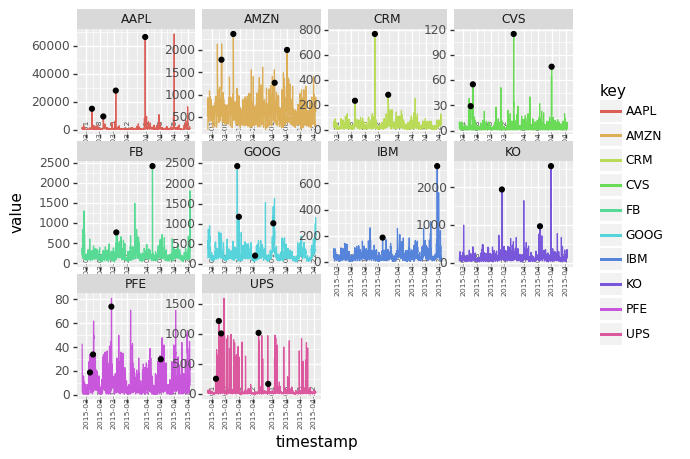

<ggplot: (-9223371863843690848)>

In [10]:
ggplot(df, aes(x='timestamp',y='value', group='key', color='key'))+ geom_line()+ theme(
  axis_text_x = element_text(size = 5.5,angle = 90, hjust = 20, vjust = -400)
)+geom_point(df[df['outlier']==1],aes(x='timestamp',y='value', group='key'), color='black')+facet_wrap('~key', scales='free') 

What you may also noticed is that anomalies point that were given by NAB benchmark wasn't entirely accurate in all case or at the very least up for interpretation.

In [11]:
obj['realTweets/Twitter_volume_AAPL.csv']

['2015-03-03 21:07:53',
 '2015-03-09 17:32:53',
 '2015-03-16 02:57:53',
 '2015-03-31 03:27:53']

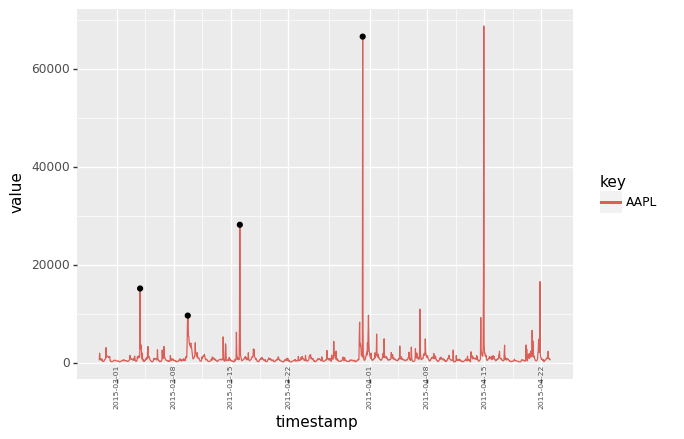

<ggplot: (-9223371863843696624)>

In [12]:
ggplot(df[df['key']=='AAPL'], aes(x='timestamp',y='value', group='key', color='key'))+ geom_line()+ theme(
  axis_text_x = element_text(size = 5.5,angle = 90, hjust = 20, vjust = -400)
)+geom_point(df[(df['outlier']==1)&(df['key']=='AAPL')],aes(x='timestamp',y='value', group='key'), color='black')


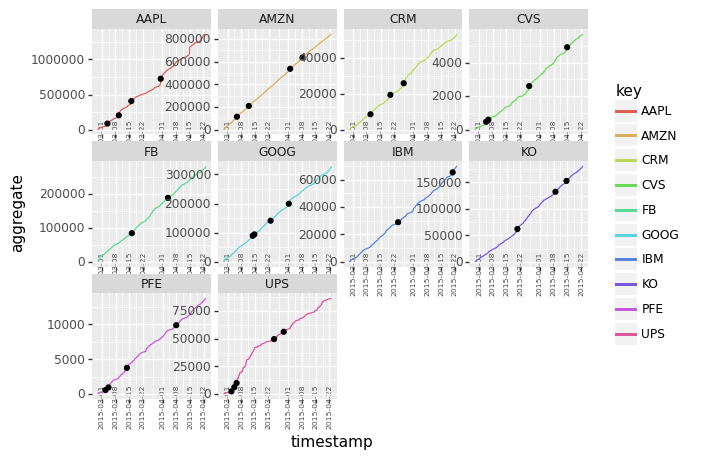

<ggplot: (-9223371863843323416)>

In [13]:
ggplot(df, aes(x='timestamp',y='aggregate', group='key', color='key'))+ geom_line()+ theme(
  axis_text_x = element_text(size = 5.5,angle = 90, hjust = 20, vjust = -400)
)+geom_point(df[df['outlier']==1],aes(x='timestamp',y='aggregate', group='key'), color='black')+facet_wrap('~key', scales='free') 

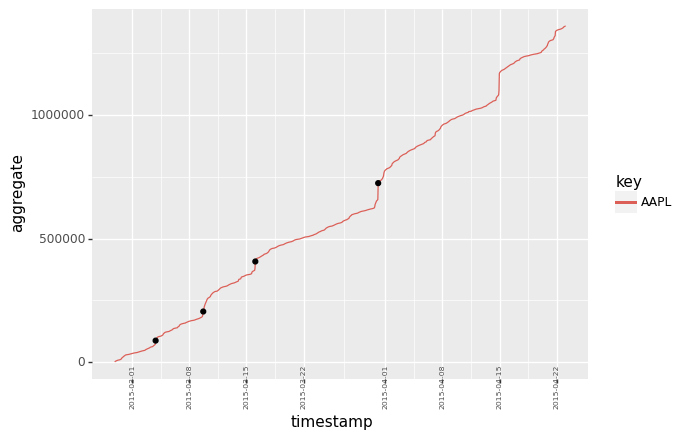

<ggplot: (-9223371863842506756)>

In [14]:
ggplot(df[df['key']=='AAPL'], aes(x='timestamp',y='aggregate', group='key', color='key'))+ geom_line()+ theme(
  axis_text_x = element_text(size = 5.5,angle = 90, hjust = 20, vjust = -400)
)+geom_point(df[(df['outlier']==1)&(df['key']=='AAPL')],aes(x='timestamp',y='aggregate', group='key'), color='black')

## Anomalies

We do some basic visualization to understand what kind of anomalies existed in this example dataset. An anomaly (or outlier) is the deviation in a quantity from its expected value. Anomaly detection is the search of that which ‘does not conform’ with expected value.

* Point Anomaly
![Point Anomaly](global-outlier.png)
* Contextual Anomaly
![Anomaly](contextual-outlier.png)
* Collective Anomaly
![Anomaly](collective-outliers.png)

## Using ARIMA Forecasting to detect anomalies

One of the most simple way of detecting anomalies is to use time-series prediction. Essentially, anomalies is about finding datapoint that is out of ordinary. Time series forecasting helps us estimate that ordinary which we can then use to detect anomalies by comparing them with actual data. 

This obviously relies on good forecasting model, but it also means that any forecasting model is compatible with this idea.

* Exponential Smoothing
* ARIMA
* LSTM

In this instance, we will simply use ARIMA.

In [15]:
AnomaliesData = df[df['key']=='AAPL']
train, test = (AnomaliesData.value[0:-48]), (AnomaliesData.value[-48:])
train_log, test_log = np.log10(train), np.log10(test) # take log to scale
AnomaliesData

,timestamp,key,value,aggregate,total,outlier
0,2015-02-26 21:00:00,AAPL,457,457,1181,0.0
1,2015-02-26 22:00:00,AAPL,1906,2363,3961,0.0
2,2015-02-26 23:00:00,AAPL,973,3336,2520,0.0
3,2015-02-27 00:00:00,AAPL,707,4043,2275,0.0
4,2015-02-27 01:00:00,AAPL,527,4570,1977,0.0
...,...,...,...,...,...,...
1319,2015-04-22 22:00:00,AAPL,843,1357903,1093,0.0
1320,2015-04-22 23:00:00,AAPL,670,1358573,777,0.0
1321,2015-04-23 00:00:00,AAPL,718,1359291,793,0.0
1322,2015-04-23 01:00:00,AAPL,717,1360008,790,0.0


Determine P,D,Q through ACF and PACF table, alternatively use grid search according to either AIC, AICc or BIC value

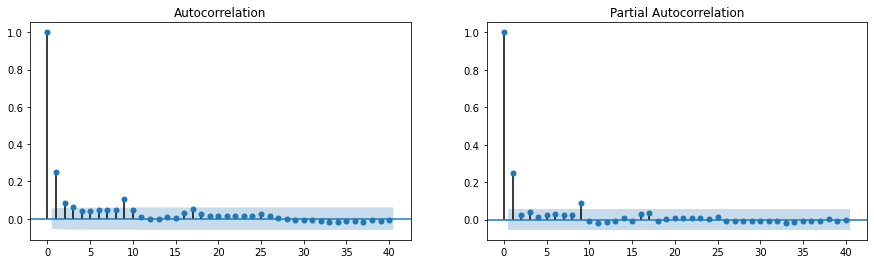

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(train, lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(train, lags=40, ax=axes[1])

In [17]:
order_pdq = (1, 1, 1)
seasonal_order_pdq = (0, 1, 1, 6)
datapoint = [x for x in train_log]
model = sm.tsa.SARIMAX(datapoint, order=order_pdq, seasonal_order=seasonal_order_pdq,enforce_stationarity=False,enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1276
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 6)   Log Likelihood                 181.208
Date:                           Wed, 22 Jul 2020   AIC                           -354.416
Time:                                   11:34:35   BIC                           -333.857
Sample:                                        0   HQIC                          -346.690
                                          - 1276                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7932      0.012     66.069      0.000       0.770       0.817
ma.L1         -1.0000      1.930     -0.518

We are not trying to predict everything from scratch, but rather use information at each stage to predict what is likely to be the next stage. So instead of train/test split that are norm in forecasting, we reuse the data at every stage and make prediction only for the next datapoint.

In [18]:
predictions = list()
predict_log=list()
for t in range(len(test_log)):
    model = sm.tsa.SARIMAX(datapoint, order=order_pdq, seasonal_order=seasonal_order_pdq,enforce_stationarity=False,enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log.iloc[t]
    datapoint.append(obs)
predictions = pd.Series(predictions)
predictions.index = test.index

C:\Users\Aritad Choicharoon\.conda\envs\pytorch\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


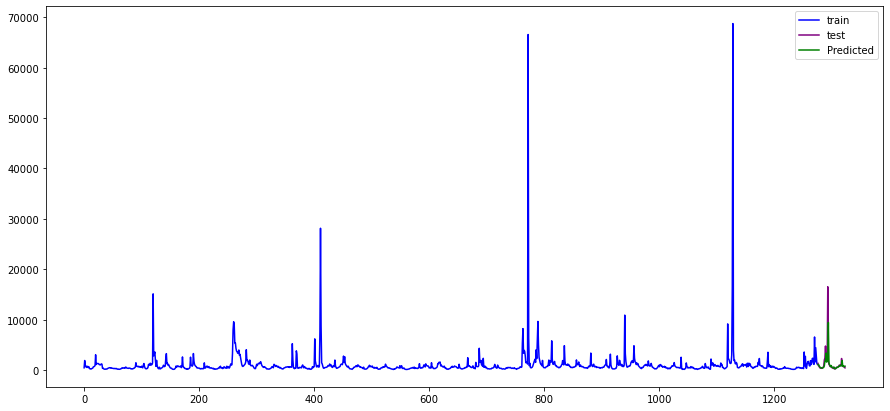

In [19]:
figsize=(15, 7)
plt.figure(figsize=figsize)
pyplot.plot(train,label='train', color='blue')
pyplot.plot(test,label='test', color='purple')
pyplot.plot(predictions, color='green',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

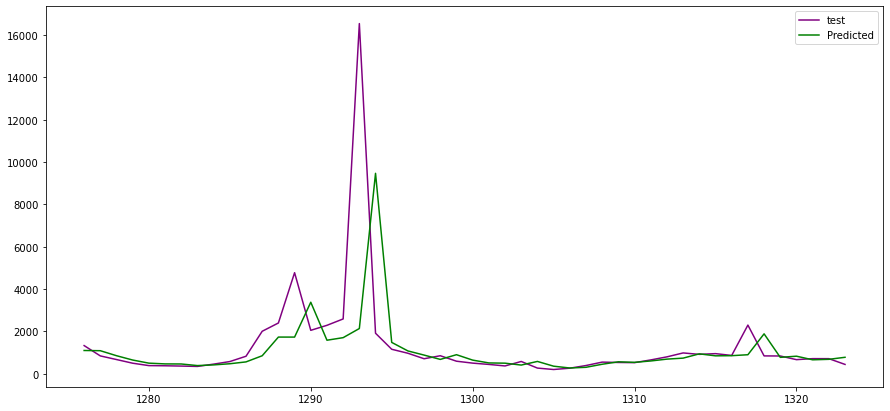

In [20]:
figsize=(15, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='test', color='purple')
pyplot.plot(predictions, color='green',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()

In [21]:
predicted_df=pd.DataFrame()
predicted_df['load_date']=AnomaliesData['timestamp'][-48:]
predicted_df['actuals']=test
predicted_df['predicted']=predictions
predicted_df.reset_index(inplace=True)
del predicted_df['index']
predicted_df.head()

,load_date,actuals,predicted
0,2015-04-21 03:00:00,1334,1102.551435
1,2015-04-21 04:00:00,847,1092.374282
2,2015-04-21 05:00:00,675,856.376079
3,2015-04-21 06:00:00,502,651.813247
4,2015-04-21 07:00:00,389,504.849069


What we have now is the real and predicted data, we just need to look at the average and distribution of the 'error' of our model to create potential approximate 'normal' pattern.

Subsequently, anything outside of that pattern is a potential anomalies.

In [25]:
import numpy as np
def anomalies(df,rollingwindows):
    df['error']=df['actuals']-df['predicted']
    df['meanerror'] = df['error'].rolling(window=rollingwindows).mean()
    df['deviationerror'] = df['error'].rolling(window=rollingwindows).std()
    df['-3sderror'] = df['meanerror'] - (3 * df['deviationerror'])
    df['3sderror'] = df['meanerror'] + (3 * df['deviationerror'])
    df['-2sderror'] = df['meanerror'] - (2 * df['deviationerror'])
    df['2sderror'] = df['meanerror'] + (2 * df['deviationerror'])
    df['-1sderror'] = df['meanerror'] - (1 * df['deviationerror'])
    df['1sderror'] = df['meanerror'] + (1 * df['deviationerror'])
    cut_list = df[['error', '-3sderror', '-2sderror', '-1sderror', 'meanerror', '1sderror', '2sderror', '3sderror']]
    cut_sort = np.sort(cut_list.values)
    df['Anomalies_Strength'] = [(lambda number: np.where(cut_sort == df['error'][number])[1][0])(number)\
                                for number in range(len(df['error']))]
    severity = {0: 'Severe Anomaly', 1: 'Anomaly', 2: 'Unusual', 3: 'Normal', 4: 'Normal',
                5: 'Unusual', 6: 'Anomaly', 7: 'Severe Anomaly'}
    df['Anomalies_Strength'] =  df['Anomalies_Strength'].map(severity)
    df['anomaly_points'] = np.where(df['Anomalies_Strength'] == 'Severe Anomaly', df['error'], np.nan)
    df = df.sort_values(by='load_date', ascending=False)
    df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y-%m-%d")
    df[-rollingwindows:]['anomaly_points'] = np.NaN
    df[-rollingwindows:]['Anomalies_Strength'] = 'Normal'
    df['upper_boundary'] = df['predicted']+df['1sderror']
    df['lower_boundary'] = df['predicted']+df['-1sderror']
    df['upper_boundary_high'] = df['predicted']+df['3sderror']
    df['lower_boundary_high'] = df['predicted']+df['-3sderror']
    df = df.drop(columns=['1sderror', '-1sderror','2sderror','-2sderror','-3sderror','3sderror'])
    return df

In [26]:
classify_df=anomalies(predicted_df,12)

C:\Users\Aritad Choicharoon\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Aritad Choicharoon\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\Aritad Choicharoon\.conda\envs\pytorch\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 11 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


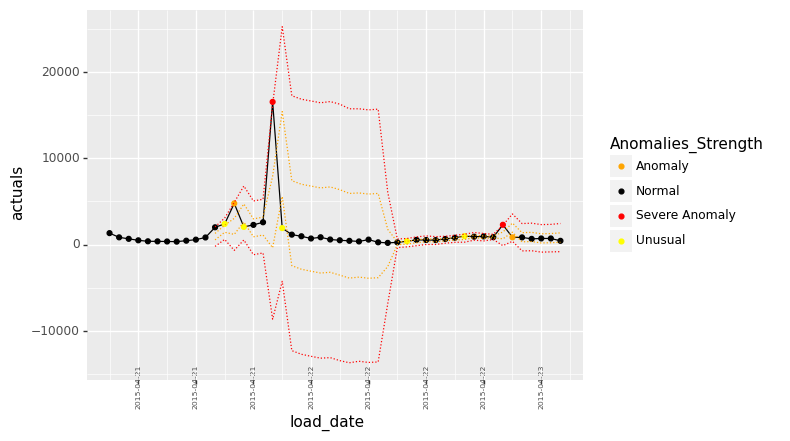

<ggplot: (-9223371863838687880)>

In [27]:
ggplot(classify_df)+ geom_line(aes(x='load_date',y='actuals')) \
+ geom_point(aes(x='load_date',y='actuals',color='Anomalies_Strength'))+\
  scale_color_manual(values = {'Normal':"black",'Anomaly':"orange",'Severe Anomaly':"red",'Unusual':'yellow'})\
+theme(axis_text_x = element_text(size = 5.5,angle = 90, hjust = 20, vjust = -400))\
+geom_line(aes(x='load_date',y='upper_boundary'),color='orange',linetype="dotted")\
+geom_line(aes(x='load_date',y='lower_boundary'),color='orange',linetype="dotted")\
+geom_line(aes(x='load_date',y='upper_boundary_high'),color='red',linetype="dotted")\
+geom_line(aes(x='load_date',y='lower_boundary_high'),color='red',linetype="dotted")

In [28]:
classify_df.head()

,load_date,actuals,predicted,error,meanerror,deviationerror,Anomalies_Strength,anomaly_points,upper_boundary,lower_boundary,upper_boundary_high,lower_boundary_high
47,2015-04-23 02:00:00,445,781.473901,-336.473901,37.694989,543.898987,Normal,NaN,1363.067876,275.269902,2450.865850,-812.528072
46,2015-04-23 01:00:00,717,685.507299,31.492701,69.815315,531.022288,Normal,NaN,1286.344902,224.300326,2348.389478,-837.744250
45,2015-04-23 00:00:00,718,662.784786,55.215214,66.034566,531.481250,Normal,NaN,1260.300602,197.338102,2323.263101,-865.624397
44,2015-04-22 23:00:00,670,833.270450,-163.270450,58.808554,532.230662,Normal,NaN,1424.309666,359.848342,2488.770991,-704.612983
43,2015-04-22 22:00:00,843,778.258828,64.741172,80.825209,527.653687,Normal,NaN,1386.737724,331.430351,2442.045097,-723.877022


## Kleinberg's Burst Detection

http://www.cs.cornell.edu/home/kleinber/bhs.pdf

Kleinberg’s algorithm identifies periods of time in which an event of particular interest is uncharacteristically frequent, or “bursty.”  It can be used to detect bursts in a continuous stream or batches of events by assumeing that there are only two possible states, the baseline state and the 'bursty' state. 

The probability of event of interest happening in baseline state is equal to the total number of event of interest divided by total number of events. The 'bursty' state probability is constant multiplied by baseline probability.


* pybursts (Continuous stream) = https://github.com/romain-fontugne/pybursts (Forked version which fix some problem)
* burst_detection (Batch event) = https://github.com/nmarinsek/burst_detection

The total cost of transitioning from normal state to burst is equal to the sum of the two functions below. With the cost function, we can then find the optimal state sequence that tell us what is the state at each timepoint 

The goodness of fit between the observed proportion and the expected probability of each state.

$\sigma(i,r_t,d_t)= - ln[\binom{d_t}{r_t}p_i^{rt}(1-p_i)^{d_t-r_t}]$

The difficulty of transitioning from the previous state to the next state.

$\tau= - (i_{next}-i_{prev})*\gamma*ln(n)$

In [29]:
AnomaliesData_Start = df[df['key']=='AAPL']
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(AnomaliesData_Start[['value','total']])
AnomaliesData = pd.DataFrame(np_scaled*100, columns = ['value','total']) 
#Scaled the data because of issue with binomial coefficient
r = pd.Series(AnomaliesData['value']).astype('float')
d = pd.Series(AnomaliesData['total']).astype('float')
AnomaliesData

,value,total
0,0.492525,1.004743
1,2.603969,5.000719
2,1.244426,2.929424
3,0.856818,2.577260
4,0.594527,2.148915
...,...,...
1319,1.054994,0.878252
1320,0.802903,0.424033
1321,0.872847,0.447032
1322,0.871390,0.442720


Burst Detection Function: burst_detection(r,d,len(r),s,d,smooth_win)

* r = number of events of interested
* d = number of all events
* s = distance between normal state and a burst state
* g = cost to move from normal state to a burst state.
* smooth_win = smoothing windows



In [30]:
[q, _, _, p] = bd.burst_detection(r,d,len(r),2,1,smooth_win=5)
bursts = bd.enumerate_bursts(q, 's='+str(3)+', g='+str(1))
bursts = bd.burst_weights(bursts, r, d, p)

C:\Users\Aritad Choicharoon\.conda\envs\pytorch\lib\site-packages\burst_detection-0.1-py3.7.egg\burst_detection\__init__.py:97: RuntimeWarning: invalid value encountered in greater
  if (burst==False) & (q[t] > q[t-1]):
C:\Users\Aritad Choicharoon\.conda\envs\pytorch\lib\site-packages\burst_detection-0.1-py3.7.egg\burst_detection\__init__.py:101: RuntimeWarning: invalid value encountered in less
  if (burst==True) & (q[t] < q[t-1]):


In [31]:
data_r = pd.DataFrame({'day':range(len(r)),'data':r,'total':d,'outlier':AnomaliesData_Start['outlier']})
data_r['Prediction'] = 0
for index, row in bursts.iterrows():
    data_r['Prediction'] = np.where(data_r['day']>=row.begin,np.where(data_r['day']<=row.end,1,data_r['Prediction']), data_r['Prediction'])

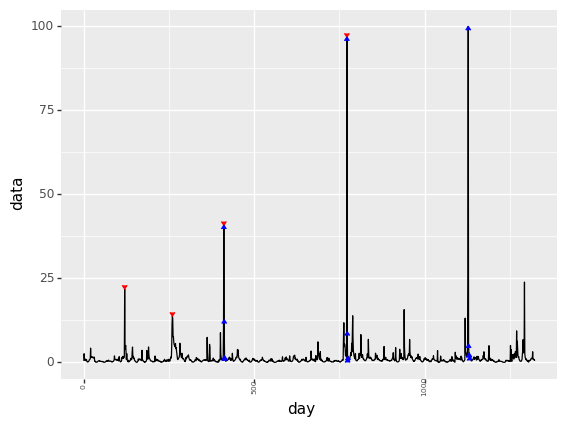

<ggplot: (-9223371863838492128)>

In [32]:
ggplot(data_r, aes(x='day',y='data'))+ geom_line()+ theme(
  axis_text_x = element_text(size = 5.5,angle = 90, hjust = 20, vjust = -400)
)+geom_point(data_r[(data_r['outlier']==1)],aes(x='day',y='data'), color='red',shape = 7)+geom_point(data_r[(data_r['Prediction']==1)],aes(x='day',y='data'), color='blue',shape = 6)

The strength, or weight, of a burst (that begins at time point t1 and ends at time point t2) can be estimated with the following function:

In [33]:
def plot_burst_timeline(bursts, timepoints):
    
    f, ax = plt.subplots(figsize=(8, 0.5))
    ax.set(xlim=(0, timepoints), ylabel="", xlabel="")

    #create boxes around bursting periods
    for index, burst in bursts.iterrows():

        #define outline positions
        y = 0.25
        xstart = burst['begin'] -1 
        width = burst['end'] - burst['begin'] +1

        ax.add_patch(Rectangle((xstart,y), width, height=0.5, 
                               facecolor='#00bbcc', edgecolor='none', linewidth=1))

    ax.xaxis.set_visible(False)

    plt.axhline(0.5, linewidth=1, color='k', alpha=1, zorder=0.5)
    plt.show()

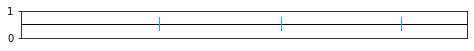

In [34]:
plot_burst_timeline(bursts, len(r))